# Scalar advection-diffusion using a parallel-in-time method

Now that we are familiar with scalar advection-diffusion, we will solve it using the parallel-in-time method ParaDiag.
We write the scalar advection-diffusion equations as:
$$
\partial_{t}q + u\partial_{x}q - \nu\partial^{2}_{xx}q = \partial_{t}q + \textbf{K}q = 0
$$
with $\textbf{K}$ containing the spatial terms.

The implicit theta method discretisation then looks like:

$$
\frac{q^{n+1}-q^{n}}{\Delta t} + \theta \textbf{K}q^{n+1} + (1-\theta)\textbf{K}q^{n} = 0
$$

We can now construct the all-at-once system which couples all timesteps in the time-series together into a single problem. For 4 timesteps this looks like:

$$
\left(
\frac{1}{\Delta t}
\begin{pmatrix}
 1 &  0 &  0 & 0 \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\otimes\textbf{I}_{x}
+
\begin{pmatrix}
\theta     & 0          & 0          & 0 \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\otimes\textbf{K}
\right)
\begin{pmatrix}
q^{1} \\ q^{2} \\ q^{3} \\ q^{4} \\
\end{pmatrix}
=
\textbf{b}
$$

where $\otimes$ is the [kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) and $\textbf{I}_{x}$ is the identity matrix of size $n_{x}\times n_{x}$.
As with Dalhquist's equation, the left hand side can be written using the two Toeplitz matrices $\textbf{B}_{1}$ and $\textbf{B}_{2}$ which define the implicit theta method:

$$
\textbf{A}\textbf{q} = \left(\frac{1}{\Delta t}\textbf{B}_{1}\otimes\textbf{I}_{x} + \textbf{B}_{2}\otimes\textbf{K}\right)\textbf{q}
$$

Where $\textbf{A}$ is the all-at-once Jacobian, and $\textbf{q}$ is the vector of the timeseries $q^{n}$.

The right hand side vector $\textbf{b}$ contains the initial condition:

$$
\begin{pmatrix}
q^{0}/\Delta t - (1-\theta)\textbf{K}q^{0} \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$

## Implementing the all-at-once system

We start as for the serial method by defining the problem parameters.

In [1]:
nt = 128
nx = 256

lx = 256.
dx = lx/nx

# width of initial profile
width = lx/4

theta = 0.5

# velocity, CFL, and reynolds number
u = 1
re = 200
cfl = 0.8

# viscosity
nu = width*u/re

# timestep
dt = cfl*dx/u

cfl_u = cfl
cfl_v = nu*dt/dx**2

print("nu, dt, cfl_v, cfl_u")
print( nu, dt, cfl_v, cfl_u )

nu, dt, cfl_v, cfl_u
0.32 0.8 0.256 0.8


Because we will be using GMRES to solve the all-at-once system, we will need to implement a `LinearOperator` to carry out a matrix-vector product with the all-at-once Jacobian $\textbf{A}$. This will be built from `LinearOperator`s describing the matrix-vector product of each block in the all-at-once Jacobian. There are two unique blocks, which are repeated on each (block) row.
We can see this by rearranging the theta method discretisation to group the terms involving each timestep together:

$$
\left(\frac{-\textbf{I}_{x}}{\Delta t} + (1-\theta)\textbf{K}\right)q^{n} +
\left(\frac{\textbf{I}_{x}}{\Delta t} + \theta \textbf{K}\right)q^{n+1}
= \textbf{A}_{0}q^{n} + \textbf{A}_{1}q^{n+1} = 0
$$

We will use the same finite difference discretisation for the spatial terms, so we need to again set up the circulant matrices describing this discretisation.


In [2]:
import numpy as np

# spatial mesh
x = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)

# identity
I = np.zeros_like(x)
I[0] = 1

# gradient matrix for the advection term
Ka = np.zeros_like(x)
Ka[-1] = 1/(2*dx)
Ka[1] = -1/(2*dx)

# laplacian matrix for the diffusion term
Kd = np.zeros_like(x)
Kd[-1] = 1/dx**2
Kd[0] = -2/dx**2
Kd[1] = 1/dx**2

# full spatial residual matrix
K = u*Ka - nu*Kd

# columns of the right/left hand side matrices
a0_col = -I/dt + (1-theta)*K
a1_col = I/dt + theta*K

The only difference to the `CirculantLinearOperator` we have used previously is that we now distinguish whether or not we are dealing with a real or complex valued matrix when returning the result of the matrix-vector product. This will be necessary later.

In [3]:
from scipy.sparse import linalg as spla
from scipy import linalg
from scipy.fft import fft, ifft

class CirculantLinearOperator(spla.LinearOperator):
    def __init__(self, col, inverse=True):
        self.dtype = col.dtype
        self.shape = tuple((len(col), len(col)))
        self.col = col
        self.is_complex = np.iscomplexobj(col)

        self.eigvals = fft(col, norm='backward')
        
        if inverse:
            self.op = self._solve
        else:
            self.op = self._mul
    
    def _mul(self, v):
        return ifft(fft(v)*self.eigvals)
    
    def _solve(self, v):
        return ifft(fft(v)/self.eigvals)

    def _matvec(self, v):
        y = self.op(v)
        if self.is_complex: return y
        else: return y.real

The two operators for the blocks of the all-at-once matrix are:

In [4]:
A0 = CirculantLinearOperator(a0_col, inverse=False)
A1 = CirculantLinearOperator(a1_col, inverse=False)

Next we need to build the `LinearOperator` for the block Toeplitz all-at-once system. Complete the `LinearOperator` skeleton below to implement this. The class needs the number of timesteps and the `LinearOperator` for each block.

_The argument of `_matvec` will have shape `(nt*nx,)`, but you may find it easier to implement the matrix-vector product by first reshaping to `(nt,nx)`. Remember to reshape back again before returning the result!_

In [5]:
class AllAtOnceLinearOperator(spla.LinearOperator):
    def __init__(self, nt, A0, A1):
        self.dtype = A0.dtype
        
        self.nt = nt
        self.nx = A0.shape[0]

        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))

        self.A0 = A0
        self.A1 = A1

    def _matvec(self, v):
        v = v.reshape((self.nt, self.nx))                                  
        w = np.zeros_like(v)

        w[0]+= self.A1.matvec(v[0])
        for b in range(1, self.nt):
            w[b]+= self.A0.matvec(v[b-1])
            w[b]+= self.A1.matvec(v[b])

        return w.reshape(self.dim)

A = AllAtOnceLinearOperator(nt, A0, A1)

Now we have our numerical scheme set up, time for the initial conditions and the right hand side of the all-at-once system. We use the same initial condition as we did when solving serially in time.

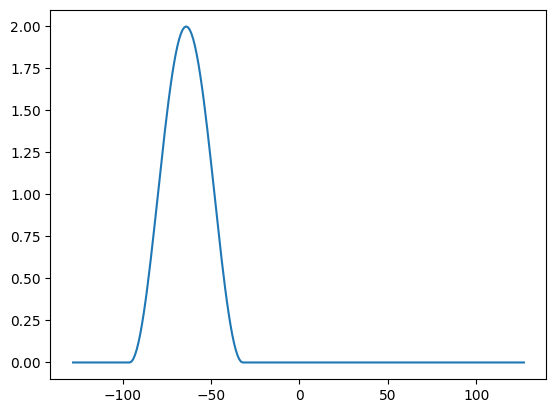

In [6]:
from math import pi

qinit = np.zeros_like(x)
qinit[:] =  1 + np.cos(np.minimum(2*pi*np.abs(x+lx/4)/width, pi))

q = np.zeros((nt,nx))
rhs = np.zeros_like(q)

rhs[0] -= A0.matvec(qinit)

rhs = rhs.reshape(nt*nx)
q = q.reshape(nt*nx)

import matplotlib.pyplot as plt
plt.plot(x, qinit)
plt.show()

We will first try to solve the all-at-once system with brute force by unpreconditioned GMRES. Let's see how that goes.

In [8]:
niterations=0
def gmres_callback(y):
    global niterations
    print(f"niterations: {str(niterations).rjust(3,' ')}  |  residual:  {y}")
    niterations += 1
    return

q, exit_code = spla.gmres(A, rhs,
                          callback=gmres_callback,
                          callback_type='pr_norm')

niterations:   0  |  residual:  0.7069976254446976
niterations:   1  |  residual:  0.5771720749203463
niterations:   2  |  residual:  0.49976858621514414
niterations:   3  |  residual:  0.44693769114206927
niterations:   4  |  residual:  0.40793353331496623
niterations:   5  |  residual:  0.3776148561346641
niterations:   6  |  residual:  0.353171919254285
niterations:   7  |  residual:  0.3329223692774492
niterations:   8  |  residual:  0.31578922695477774
niterations:   9  |  residual:  0.3010468288697873
niterations:  10  |  residual:  0.2881860041731764
niterations:  11  |  residual:  0.2768375367813178
niterations:  12  |  residual:  0.2667262986909992
niterations:  13  |  residual:  0.2576425131892018
niterations:  14  |  residual:  0.2494230675158541
niterations:  15  |  residual:  0.2419389703543599
niterations:  16  |  residual:  0.23508670204401633
niterations:  17  |  residual:  0.22878210781628633
niterations:  18  |  residual:  0.2229559980824615
niterations:  19  |  resid

niterations: 176  |  residual:  0.10140430104656513
niterations: 177  |  residual:  0.10123088444354415
niterations: 178  |  residual:  0.10103267602465421
niterations: 179  |  residual:  0.10086278115108414
niterations: 180  |  residual:  0.1006992883569497
niterations: 181  |  residual:  0.10050405936773539
niterations: 182  |  residual:  0.10033115740136321
niterations: 183  |  residual:  0.10012521006305183
niterations: 184  |  residual:  0.09991910860252691
niterations: 185  |  residual:  0.09968776062574004
niterations: 186  |  residual:  0.09946092497599868
niterations: 187  |  residual:  0.09923018693506243
niterations: 188  |  residual:  0.09900115501105101
niterations: 189  |  residual:  0.0987702903712251
niterations: 190  |  residual:  0.09852432891658963
niterations: 191  |  residual:  0.09827736299085105
niterations: 192  |  residual:  0.09802451032200415
niterations: 193  |  residual:  0.09777807126388638
niterations: 194  |  residual:  0.09752498412581645
niterations: 1

niterations: 356  |  residual:  0.0009132394870037951
niterations: 357  |  residual:  0.000900279341395303
niterations: 358  |  residual:  0.0008841536169909278
niterations: 359  |  residual:  0.0008614895013797981
niterations: 360  |  residual:  0.0008402232136943396
niterations: 361  |  residual:  0.0008192427846956346
niterations: 362  |  residual:  0.0007987179251714686
niterations: 363  |  residual:  0.0007682184905928783
niterations: 364  |  residual:  0.0007374820410243784
niterations: 365  |  residual:  0.0006974560874894369
niterations: 366  |  residual:  0.0006550845732812674
niterations: 367  |  residual:  0.0006171909842716194
niterations: 368  |  residual:  0.0005803555193472365
niterations: 369  |  residual:  0.0005426858939522001
niterations: 370  |  residual:  0.0005060174341148899
niterations: 371  |  residual:  0.00047343732410853954
niterations: 372  |  residual:  0.00044238783704791674
niterations: 373  |  residual:  0.00041231342816974763
niterations: 374  |  resid

In [9]:
print(f"gmres exit code: {exit_code}")                                                                                                                 
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(q))}")

gmres exit code: 0
gmres iterations: 440
residual: 9.880253499421286e-05


Just as with Dahlquist's ODE we see that the unpreconditioned all-at-once system takes many GMRES iterations to solve (this isn't unique to all-at-once matrices, it is very common for Krylov methods to perform poorly without appropriate preconditioning). We will again try to reduce the number of iterations needed for the GMRES solve using a circulant preconditioner. This time the preconditioner will be block circulant, with blocks of size $n_{x}\times n_{x}$ to match the blocks of the all-at-once Jacobian. We will go straight to considering the $\alpha$-circulant preconditioner.

The $\alpha$-circulant preconditioner has the following form:

$$
\textbf{P} =
\frac{1}{\Delta t}
\begin{pmatrix}
 1 &  0 &  0 & -\alpha \\
-1 &  1 &  0 & 0 \\
 0 & -1 &  1 & 0 \\
 0 &  0 & -1 & 1 \\
\end{pmatrix}
\otimes\textbf{I}_{x}
+
\begin{pmatrix}
\theta     & 0          & 0          & \alpha(1-\theta) \\
(1-\theta) & \theta     & 0          & 0 \\
0          & (1-\theta) & \theta     & 0 \\
0          & 0          & (1-\theta) & \theta \\
\end{pmatrix}
\otimes\textbf{K}
$$

which can be written more compactly as:

$$
\textbf{P} = \textbf{C}^{(\alpha)}_{1}\otimes\textbf{I}_{x} + \textbf{C}^{(\alpha)}_{2}\otimes\textbf{K}
$$

It is a property of the [Kronecker product $\otimes$](https://en.wikipedia.org/wiki/Kronecker_product) that if $\textbf{U}$, $\textbf{V}$ are $m\times m$ matrices and $\textbf{X}$, $\textbf{Y}$ are $n\times n$ matrices, then:

$$
\left(\textbf{UV}\right)\otimes\left(\textbf{XY}\right)
=
\left(\textbf{U} \otimes \textbf{X}\right)\left(\textbf{V} \otimes \textbf{Y}\right)
$$

This property can be used to show that if $\textbf{C}$ admits the factorisation:

$$
\textbf{C} = \textbf{V}\textbf{D}\textbf{V}^{-1}
$$

then the Kronecker product with this matrix admits the factorisation:

$$
\textbf{C}\otimes\textbf{K} =
\left(\textbf{V}\otimes\textbf{I}\right)
\left(\textbf{D}\otimes\textbf{K}\right)
\left(\textbf{V}^{-1}\otimes\textbf{I}\right)
$$

where $\textbf{I}$ is the identity matrix with the same size as $\textbf{K}$. Remember that the two circulant matrices $\textbf{C}^{(\alpha)}_{1,2}$ in our preconditioner can be simultaneously diagonalised. Combining this with the Kronecker product property above, we can see that our preconditioner can be factorised as:

$$
\textbf{P} =
\left(\textbf{V}\otimes\textbf{I}_{x}\right)
\left(\textbf{D}_{1}\otimes\textbf{I}_{x} + \textbf{D}_{2}\otimes\textbf{K}\right)
\left(\textbf{V}^{-1}\otimes\textbf{I}_{x}\right)
$$

There are two important points to note about this factorisation.
1. The action of $\left(\textbf{V}^{-1}\otimes\textbf{I}_{x}\right)$ on an all-at-once vector (i.e. a vector of size $n_{t}n_{x}$ arranged as the concatenation of $n_{t}$ vectors of size $n_{x}$) is equivalent to multiplying the time series at each grid point by the matrix $\textbf{V}^{-1}$. For $\alpha=1$ where $\textbf{V}^{-1}$ is the DFT matrix, this is equivalent to applying a Fourier transform in time at each grid point.
2. Because $\textbf{D}_{i}=\texttt{diag}(\lambda_{i,n}),\, i=1,2$ are diagonal matrices of the eigenvalues $\lambda$ of $\textbf{C}^{(\alpha)}_{1,2}$, the matrix in the middle set of brackets is block diagonal, meaning that each of these blocks can be solved _independently_.

We can now write the three steps for efficiently solving systems of the form $\textbf{P}\textbf{x}=\textbf{b}$

1. Apply the matrix $\textbf{V}^{-1}$ to the timeseries at each grid point:
    $\textbf{y}_{1}=(\textbf{V}^{-1}\otimes\textbf{I}_{x})\textbf{b}$
2. Solve the block diagonal matrix by splitting the vector $\textbf{y}$ into $n_{t}$ vectors of size $n_{x}$ and inverting each block:
    $(\lambda_{1,n}\textbf{I}+\lambda_{2,n}\textbf{K})\textbf{y}_{2,n}=\textbf{y}_{1,n}\, \forall n\in[1,n_{t}]$
3. Apply the matrix $\textbf{V}$ to the timeseries at each grid point:
    $\textbf{x}=(\textbf{V}\otimes\textbf{I}_{x})\textbf{y}_{2}$

We are almost ready to implement this preconditioner, but before we do here is a reminder of the expressions for the eigenvectors and eigenvalues of the circulant matrices:
$$
\textbf{C}^{(\alpha)} = \textbf{V}\textbf{D}\textbf{V}^{-1}
$$
where:
$$
\textbf{V}^{-1} = \textbf{F}\Gamma_{\alpha},
\quad
\textbf{D} = \textbf{F}\Gamma_{\alpha}\textbf{C}[:,0]
$$
and $\Gamma_{\alpha}$ is the diagonal matrix:
$$
\Gamma_{\alpha} = \text{diag}\left(\alpha^{\frac{k-1}{N_{t}}}\right)\; \forall k \in [1, N_{t}]
$$

To implement the circulant preconditioner, we need the first column of each of the timestepping Toeplitz matrices $\textbf{B}_{1,2}$:

In [10]:
b1 = np.zeros(nt)
b1[0] = 1/dt
b1[1] = -1/dt

b2 = np.zeros(nt)
b2[0] = theta
b2[1] = 1-theta

We will also need a function to generate a `LinearOperator` to solve each block in step 2. This function should take two arguments, a pair of eigenvalues $\lambda_{1,n}$ and $\lambda_{2,n}$, and return a `LinearOperator` which will solve the matrix $\lambda_{1,n}\textbf{I}_{x}+\lambda_{2,n}\textbf{K}$.

In [11]:
def block_op(l1, l2):                                                      
    col = l1*I + l2*K
    return CirculantLinearOperator(col, inverse=True)

Now finally it is time to implement the `LinearOperator` for our preconditioner by completing the class skeleton below. The methods `_to_eigvecs`, `_block_solve`, and `_from_eigvecs` correspond to steps 1, 2, and 3 above, and should be used to implement the `_matvec` method.

_Our problem is real-valued, so remember to return only the real part of the solution vector from the `_matvec` method._

_Every step of applying the preconditioner can be formulated as either an operation on the timeseries of length $n_{t}$ at each of the $n_{x}$ mesh points, or an operation on $n_{t}$ vectors of size $n_{x}$. The `.reshape` method of NumPy arrays can make this simpler to code._

In [12]:
class BlockCirculantLinearOperator(spla.LinearOperator):
    def __init__(self, b1, b2, block_op, nx, alpha=1):
        self.nt = len(b1)
        self.nx = nx
        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))
        self.dtype = b1.dtype

        self.gamma = alpha**(np.arange(self.nt)/self.nt)

        eigvals1 = fft(b1*self.gamma, norm='backward')
        eigvals2 = fft(b2*self.gamma, norm='backward')
        eigvals = zip(eigvals1, eigvals2)

        self.blocks = tuple((block_op(l1, l2)
                             for l1, l2 in eigvals))

    def _to_eigvecs(self, v):
        y = np.matmul(np.diag(self.gamma), v)
        return fft(y, axis=0)

    def _from_eigvecs(self, v):
        y = ifft(v, axis=0)
        return np.matmul(np.diag(1/self.gamma), y)

    def _block_solve(self, v):
        for i in range(self.nt):
            v[i] = self.blocks[i].matvec(v[i])
        return v

    def _matvec(self, v):
        y = v.reshape((self.nt, self.nx))                                  
        y = self._to_eigvecs(y)
        y = self._block_solve(y)
        y = self._from_eigvecs(y)
        return y.reshape(self.dim).real

Now to test the preconditioner and see how much it improves the GMRES convergence

In [13]:
alpha = 1
P = BlockCirculantLinearOperator(b1, b2, block_op, nx, alpha)

niterations=0
q, exit_code = spla.gmres(A, rhs, M=P,
                          callback=gmres_callback,
                          callback_type='pr_norm')

print(f"gmres exit code: {exit_code}")                                                                                                                 
print(f"gmres iterations: {niterations}")
print(f"residual: {linalg.norm(rhs-A.matvec(q))}")

niterations:   0  |  residual:  7.100476072260943
niterations:   1  |  residual:  6.643338900276448
niterations:   2  |  residual:  4.497724886117485
niterations:   3  |  residual:  3.2835646754601484
niterations:   4  |  residual:  1.642277538989246
niterations:   5  |  residual:  0.9941337788256083
niterations:   6  |  residual:  0.3869496487131015
niterations:   7  |  residual:  0.21571617804239981
niterations:   8  |  residual:  0.13929895545546245
niterations:   9  |  residual:  0.059530855374245545
niterations:  10  |  residual:  0.041714748464082865
niterations:  11  |  residual:  0.03828107283126963
niterations:  12  |  residual:  0.037511562669230246
niterations:  13  |  residual:  0.036817615856058236
niterations:  14  |  residual:  0.03383386710320404
niterations:  15  |  residual:  0.023438557630830786
niterations:  16  |  residual:  0.007591331356371298
niterations:  17  |  residual:  0.005672221379103584
niterations:  18  |  residual:  0.005445264328906812
niterations:  1

That improves the convergence quite a lot! The circulant preconditioner is effective for this PDE as well as Dahlquists ODE.

Let's plot the solution to check it looks as we expect.

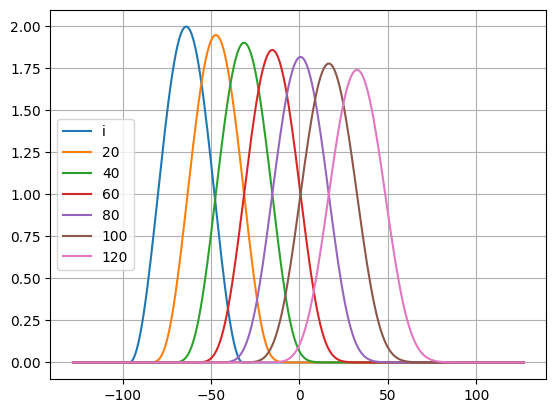

In [14]:
q = q.reshape((nt,nx))
plt.plot(x, qinit, label='i')
for i in range(20, nt+1, 20):
    plt.plot(x, q[i], label=str(i))
plt.legend(loc='center left')
plt.grid()
plt.show()

Now you can explore the behaviour of the preconditioned system. Some suggestions for questions to ask are:
- How does varying $\alpha$ affect the residuals?
- What happens when $\alpha$ approaches machine zero?
- What does the (unconverged) solution vector look like after just one iteration? After two iterations? Three?
- What happens if you change the problem parameters, e.g. `nt`, `nx`, `dt`, `re`?

Remember that you can change to tolerance of the GMRES solve using the `tol` and `atol` kwargs.
